<a href="https://colab.research.google.com/github/twishackaul/Polycystic-Ovarian-Syndrome-Classifier/blob/main/PCOS_Detection_Ultrasound_Imaging_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
import warnings
warnings .filterwarnings('ignore')

In [3]:
# ultrasound image data

!kaggle datasets download -d anaghachoudhari/pcos-detection-using-ultrasound-images

Dataset URL: https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images
License(s): unknown
 96% 121M/126M [00:02<00:00, 58.3MB/s]
100% 126M/126M [00:02<00:00, 59.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pcos-detection-using-ultrasound-images.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [5]:
import os

dataset_dir = '/content/data'
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if os.path.getsize(file_path) == 0:  # Check for zero-byte files
            print(f"Empty file detected and removed: {file_path}")
            os.remove(file_path)  # Remove the empty file

Empty file detected and removed: /content/data/test/notinfected/WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg
Empty file detected and removed: /content/data/test/notinfected/img_0_7.jpg
Empty file detected and removed: /content/data/test/notinfected/OIP (1).jpg
Empty file detected and removed: /content/data/test/notinfected/WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg
Empty file detected and removed: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg
Empty file detected and removed: /content/data/test/infected/R.jpg
Empty file detected and removed: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg
Empty file detected and removed: /content/data/test/infected/OIP.jpg
Empty file detected and removed: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg
Empty file detected and removed: /content/data/test/infected/WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/data/train",
    labels = 'inferred',
    label_mode = 'binary',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/data/test",
    labels = 'inferred',
    label_mode = 'binary',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 1924 files belonging to 2 classes.
Found 1922 files belonging to 2 classes.


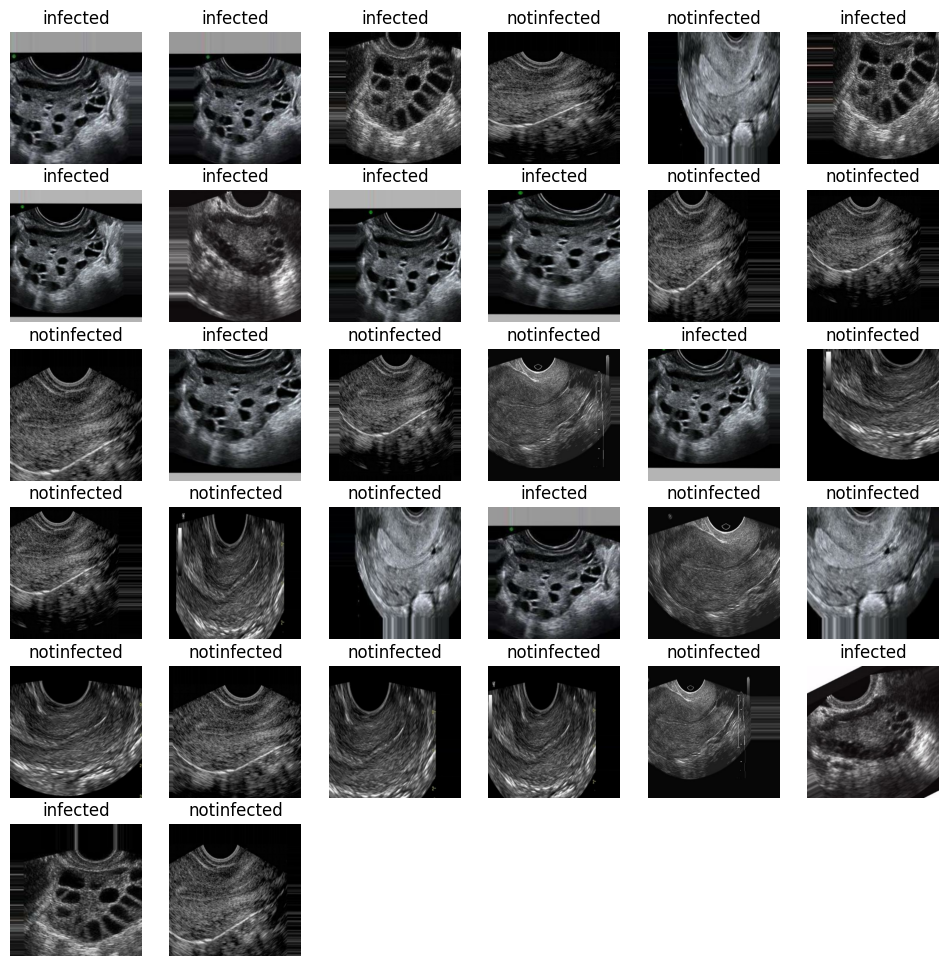

In [8]:
plt.figure(figsize=(12, 12))

# Get class names from the training dataset
class_names = train_ds.class_names

# Display a few images from the dataset
for images, labels in train_ds.take(1):                   # Adjusted to take 1 batch instead of 2
    for i in range(min(36, len(images))):                 # Display up to 36 images
        ax = plt.subplot(6, 6, i + 1)                     # Set up a 6x6 grid for displaying images
        plt.imshow(images[i].numpy().astype("uint8"))     # Display the image
        plt.title(class_names[int(labels[i].numpy())])    # Set the title as the class name
        plt.axis("off")                                   # Hide the axis for a cleaner look

plt.show()

### Data Pre-processing

In [9]:
# resizing

def resize_images(image, label):
    image = tf.image.resize(image, [256, 256])
    return image, label

In [10]:
# normalizing

def normalize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [11]:
# grayscale conversion

def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

In [12]:
train_ds = train_ds.map(resize_images)
train_ds = train_ds.map(normalize_image)
train_ds = train_ds.map(convert_to_grayscale)

validation_ds = validation_ds.map(resize_images)
validation_ds = validation_ds.map(normalize_image)
validation_ds = validation_ds.map(convert_to_grayscale)

In [13]:
for images, labels in train_ds.take(1):
    print("Grayscale image shape:", images.shape)

Grayscale image shape: (32, 256, 256, 1)


In [14]:
# Data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

def augment_image(image, label):

    augmented_image = data_augmentation(image)
    return augmented_image, label

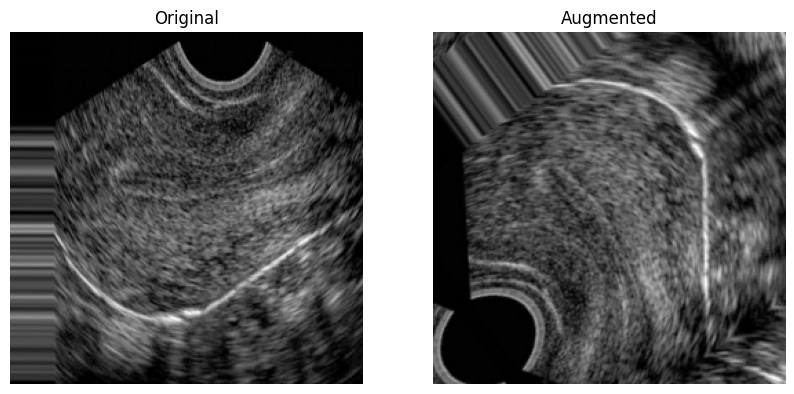

In [15]:
def plot_single_augmentation(dataset):
    plt.figure(figsize=(10, 5))
    for images, labels in dataset.take(1):
        # Original image
        ax = plt.subplot(1, 2, 1)
        plt.imshow(images[0].numpy().astype("uint8"), cmap = 'gray')
        plt.title("Original")
        plt.axis("off")

        # Apply augmentation
        image_batch = tf.expand_dims(images[0], axis=0)  # Add batch dimension
        augmented_image, _ = augment_image(image_batch, labels[0])
        augmented_image = tf.squeeze(augmented_image, axis=0)  # Remove batch dimension

        # Augmented image
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented_image.numpy().astype("uint8"), cmap = 'gray')
        plt.title("Augmented")
        plt.axis("off")

    plt.show()

# Call the function with your dataset
plot_single_augmentation(train_ds)


In [16]:
# Noise reduction function using Gaussian Blur

def reduce_noise(image, label):
    kernel = tf.constant([[1.0, 4.0, 6.0, 4.0, 1.0],
                          [4.0, 16.0, 24.0, 16.0, 4.0],
                          [6.0, 24.0, 36.0, 24.0, 6.0],
                          [4.0, 16.0, 24.0, 16.0, 4.0],
                          [1.0, 4.0, 6.0, 4.0, 1.0]], shape=[5, 5, 1, 1])

    kernel = kernel / tf.reduce_sum(kernel)
    image = tf.nn.conv2d(image[tf.newaxis, ...], kernel, strides=[1, 1, 1, 1], padding='SAME')
    image = tf.squeeze(image, axis=0)

    return image, label

train_ds = train_ds.map(reduce_noise)
train_ds = train_ds.map(augment_image)

for images, labels in train_ds.take(1):
    print("Shape after reduce_noise:", images.shape)

Shape after reduce_noise: (32, 256, 256, 1)


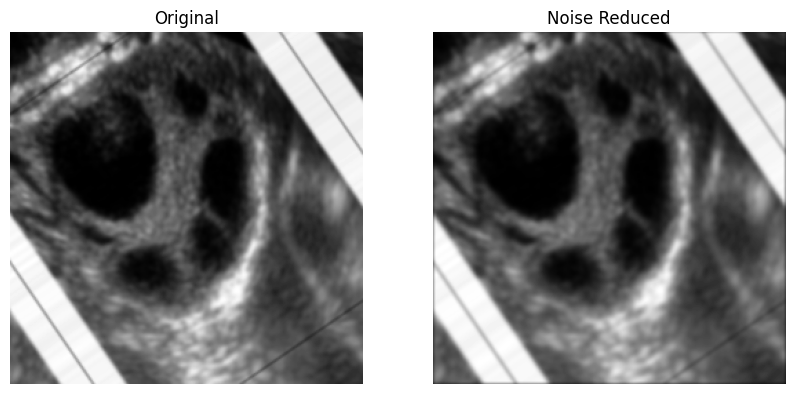

In [17]:
def plot_single_noise_reduction(dataset):
    plt.figure(figsize=(10, 5))
    for images, labels in dataset.take(1):
        # Original image
        ax = plt.subplot(1, 2, 1)
        plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Apply noise reduction
        image_batch = tf.expand_dims(images[0], axis=0)  # Add batch dimension
        noise_reduced_image, _ = reduce_noise(image_batch, labels[0])
        noise_reduced_image = tf.squeeze(noise_reduced_image, axis=0)  # Remove batch dimension

        # Noise-reduced image
        ax = plt.subplot(1, 2, 2)
        plt.imshow(noise_reduced_image.numpy().astype("uint8"), cmap='gray')
        plt.title("Noise Reduced")
        plt.axis("off")

    plt.show()

plot_single_noise_reduction(train_ds)


In [18]:
def check_image_shape(dataset):
    for element in dataset.take(1):
        # Check if dataset has labels
        if isinstance(element, tuple) and len(element) == 2:
            images, labels = element
            print(f"Image shape: {images.shape}")  # Should print (32, 256, 256, 1)
            print(f"Label shape: {labels.shape}")
        else:
            images = element
            print(f"Image shape: {images.shape}")  # Should print (32, 256, 256, 1)
        break

check_image_shape(train_ds)

Image shape: (32, 256, 256, 1)
Label shape: (32, 1)


In [19]:
for element in train_ds.take(1):
    print(type(element))
    print(element)

<class 'tuple'>
(<tf.Tensor: shape=(32, 256, 256, 1), dtype=float32, numpy=
array([[[[254.97452  ],
         [254.97452  ],
         [254.97452  ],
         ...,
         [234.67763  ],
         [234.51805  ],
         [234.96657  ]],

        [[254.97452  ],
         [254.97452  ],
         [254.97452  ],
         ...,
         [234.66351  ],
         [234.50728  ],
         [235.00064  ]],

        [[254.97452  ],
         [254.97452  ],
         [254.97452  ],
         ...,
         [234.65274  ],
         [234.54044  ],
         [235.0841   ]],

        ...,

        [[225.70993  ],
         [225.73085  ],
         [225.75177  ],
         ...,
         [  0.       ],
         [  0.       ],
         [  0.       ]],

        [[225.57327  ],
         [225.56982  ],
         [225.56639  ],
         ...,
         [  0.       ],
         [  0.       ],
         [  0.       ]],

        [[225.68643  ],
         [225.6737   ],
         [225.66098  ],
         ...,
         [  0.       ],


In [20]:
for images, labels in train_ds.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (32, 256, 256, 1)
Labels shape: (32, 1)


In [21]:
def filter_empty_images(image, label):
    image_shape = tf.shape(image)

    # Check if the image is empty (if any dimension is zero)
    is_valid = tf.reduce_all(image_shape > 0)

    # Only return non-empty images
    return is_valid

# Apply the filter to your dataset
train_ds = train_ds.filter(lambda image, label: filter_empty_images(image, label))
validation_ds = validation_ds.filter(lambda image, label: filter_empty_images(image, label))

## CNN Model

In [22]:
import random
from tensorflow.keras.regularizers import l2

In [23]:
def create_model(learning_rate=0.01, dropout_rate=0.0, l2_reg=0.001):
    ui_cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                               input_shape=(256, 256, 1), kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])

    ui_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return ui_cnn

In [24]:
# Defining the hyperparameter search space

param_random = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'l2_reg': [0.001, 0.01],  # Added L2 regularization strength
    'epochs': [10],
    'batch_size': [32]
}

In [25]:
train_images_np = []
train_labels_np = []

for images, labels in train_ds:
    train_images_np.append(images.numpy())  # Convert images to NumPy arrays and append
    train_labels_np.append(labels.numpy())  # Convert labels to NumPy arrays and append

# Stack the lists into single NumPy arrays
train_images_np = np.vstack(train_images_np)
train_labels_np = np.concatenate(train_labels_np)

In [26]:
val_images_np = []
val_labels_np = []

for images, labels in validation_ds:
    val_images_np.append(images.numpy())  # Convert images to NumPy arrays and append
    val_labels_np.append(labels.numpy())  # Convert labels to NumPy arrays and append

# Stack the lists into single NumPy arrays
val_images_np = np.vstack(val_images_np)
val_labels_np = np.concatenate(val_labels_np)

In [27]:
best_params = None
best_score = -np.inf

In [28]:
n_iter = 3

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
for _ in range(n_iter):

    learning_rate = random.choice(param_random['learning_rate'])
    dropout_rate = random.choice(param_random['dropout_rate'])
    l2_reg = random.choice(param_random['l2_reg'])  # Randomly choose L2 regularization strength
    epochs = random.choice(param_random['epochs'])
    batch_size = random.choice(param_random['batch_size'])

    print(f"Training model with Random Search = {learning_rate}, dropout = {dropout_rate}, l2_reg = {l2_reg}, epochs = {epochs}, batch_size = {batch_size}")
    model_cnn = create_model(learning_rate, dropout_rate, l2_reg)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model_cnn.fit(train_images_np, train_labels_np, validation_data = (val_images_np, val_labels_np), epochs = epochs, batch_size = batch_size, callbacks=[early_stopping], verbose = 0)

    # Get validation accuracy from the last epoch
    val_acc = history.history['val_accuracy'][-1]

    if val_acc > best_score:
        best_score = val_acc
        best_params = {
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'l2_reg': l2_reg,
            'epochs': epochs,
            'batch_size': batch_size
        }

Training model with Random Search = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 10, batch_size = 32
Training model with Random Search = 0.01, dropout = 0.2, l2_reg = 0.001, epochs = 10, batch_size = 32
Training model with Random Search = 0.01, dropout = 0.3, l2_reg = 0.001, epochs = 10, batch_size = 32
Training model with Random Search = 0.01, dropout = 0.2, l2_reg = 0.01, epochs = 10, batch_size = 32


In [31]:
final_model_cnn = create_model(learning_rate=best_params['learning_rate'], dropout_rate=best_params['dropout_rate'], l2_reg=best_params['l2_reg'])

In [32]:
history_final = final_model_cnn.fit(train_images_np, train_labels_np, validation_data=(val_images_np, val_labels_np), epochs = best_params['epochs'], batch_size = best_params['batch_size'])

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 369s 6s/step - accuracy: 0.5777 - loss: 96.8525 - val_accuracy: 0.7997 - val_loss: 11.0828
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 373s 6s/step - accuracy: 0.8526 - loss: 10.4627 - val_accuracy: 0.8554 - val_loss: 9.3214
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 354s 6s/step - accuracy: 0.9361 - loss: 8.6137 - val_accuracy: 0.9053 - val_loss: 7.8041
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 353s 6s/step - accuracy: 0.9595 - loss: 7.3928 - val_accuracy: 0.9183 - val_loss: 6.7651
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step - accuracy: 0.9805 - loss: 6.2472 - val_accuracy: 0.9194 - val_loss: 5.9070
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 372s 6s/step - accuracy: 0.9867 - loss: 5.3827 - val_accuracy: 0.9308 - val_loss: 5.1986
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.9801 - loss: 4.7769 - val_accuracy: 0.9261 - val_loss: 4.6094
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 406s 6s/step - accuracy: 0.9849 - loss: 4.2252 - val_accuracy: 0.9370 

In [33]:
final_model_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      33,554,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,745,093 (384.31 MB)

 Trainable params: 33,581,697 (128.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,163,396 (256.21 MB)

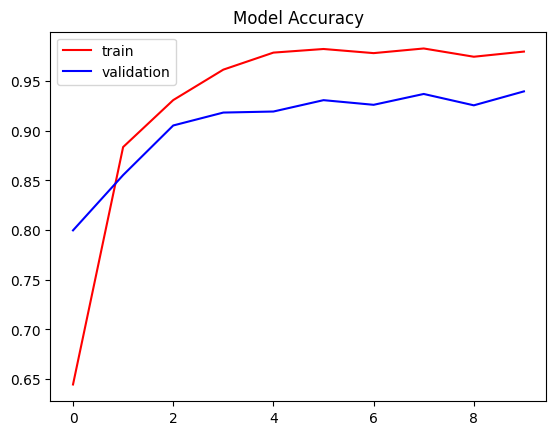

In [34]:
plt.plot(history_final.history['accuracy'], color='red', label='train')
plt.plot(history_final.history['val_accuracy'], color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

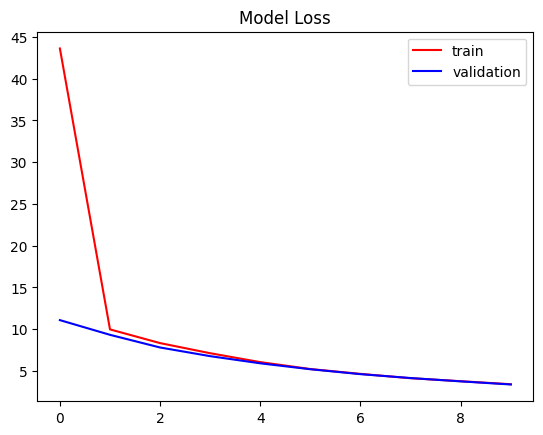

In [35]:
plt.plot(history_final.history['loss'], color='red', label='train')
plt.plot(history_final.history['val_loss'], color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [36]:
y_pred_prob = final_model_cnn.predict(val_images_np)
y_pred = (y_pred_prob > 0.5).astype("int32")

61/61 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step


In [37]:
val_labels_np = val_labels_np.flatten()
y_pred = y_pred.flatten()

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [39]:
accuracy = accuracy_score(val_labels_np, y_pred)
precision = precision_score(val_labels_np, y_pred)
recall = recall_score(val_labels_np, y_pred)
f1 = f1_score(val_labels_np, y_pred)

In [40]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9396
Precision: 0.9282
Recall: 0.9737
F1 Score: 0.9504


In [41]:
CM = confusion_matrix(val_labels_np, y_pred)
CM

array([[ 695,   86],
       [  30, 1111]])

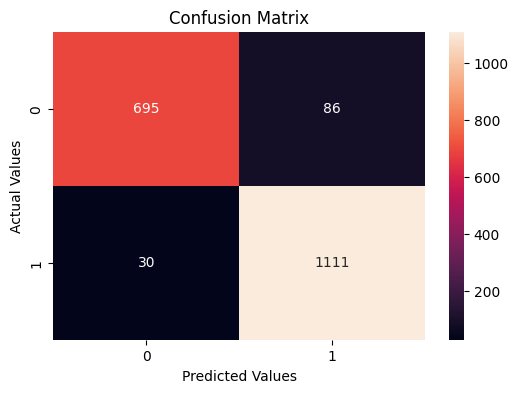

In [42]:
plt.figure(figsize = (6, 4))
sns.heatmap(CM, annot=True, fmt='d', )
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [43]:
tn, fp, fn, tp = CM.ravel()

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 1111
True Negatives (TN): 695
False Positives (FP): 86
False Negatives (FN): 30


In [45]:
final_model_cnn.save('Ultrasound_cnn.keras')